# Lucas Asset Pricing Model

## A notebook by [Christopher D. Carroll](http://www.econ2.jhu.edu/people/ccarroll/) and [Mateo Velásquez-Giraldo](https://mv77.github.io/)
### Inspired by its [Quantecon counterpart](https://julia.quantecon.org/multi_agent_models/lucas_model.html)

This notebook presents simple computational tools to solve an instance of Lucas's asset-pricing model for which there is no analytical solution: The case when the logarithm of the asset's dividend follows an autoregressive process of order 1,
\begin{equation*}
\ln d_{t+1} = \gamma + \alpha \ln d_t + \varepsilon_{t+1}, \qquad \varepsilon \sim \mathcal{N}(-\frac{\sigma^2}{2}, \sigma).
\end{equation*}

A presentation of this model can be found in [Christopher D. Carroll's lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/LucasAssetPrice/).

Those notes use [the Bellman equation](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/LucasAssetPrice/#pofc) to derive a relationship between the price of the asset in the current period $t$ and the next period $t+1$:

\begin{equation*}
P_{t} =  
\overbrace{\left(\frac{1}{1+\vartheta}\right)}
^{\beta}\mathbb{E}_{t}\left[ \frac{u^{\prime}(d_{t+1})}{u^{\prime}(d_t)} (P_{t+1} + d_{t+1}) \right]
\end{equation*}

The equilibrium pricing equation is a relationship between the price and the dividend (a "pricing kernel") $P^{*}(d)$ such that, if everyone _believes_ that to be the pricing kernel, everyone's Euler equation will be satisfied:

\begin{equation*}
P^*(d_t) =   \left(\frac{1}{1+\vartheta}\right)\mathbb{E}_{t}\left[ \frac{u^{\prime}(d_{t+1})}{u^{\prime}(d_t)} (P^*(d_{t+1}) + d_{t+1}) \right]
\end{equation*}

As noted in the handout, there are some special circumstances in which it is possible to solve for $P^{*}$ analytically:

| Shock Process | Mean Restrictions  | CRRA | Solution for Pricing Kernel $P^*(d)$  |
| --- | :-- | :--  | :---:  |
| bounded, IID, $\mathbb{E}[d]=\bar{d}$  | $0 < d < \infty$ | 1 (log) | $\vartheta^{-1}d$  |
| lognormal, mean 1 | $\mu=-\sigma^{2}/2$  | $\rho$ | $\vartheta^{-1}{d_t^\rho}~e^{\rho(\rho-1)\sigma^2/2}$  |
| lognormal mean $e^{\gamma}=\mathbb{E}[d_{t+1}/d_{t}]$  | ${\mu~=-\sigma^{2}/2+\gamma}$ |$\rho$ |  $\vartheta^{-1}d_t^{\rho}e^{\rho\gamma+\rho(\rho-1)\sigma^2/2}$  |

However, under most circumstances, the only way to obtain the pricing function $P^{*}$ is by solving for it numerically, as outlined below.

# Finding the equilibrium pricing function.

We know that the equilibrium pricing function must satisfy the equation above. Let's define an operator that allows us to evaluate whether any candidate pricing function satisfies this requirement.

Let $T$ be an operator which takes as argument a function and returns another function (these are usually called [functionals or higher-order functions](https://en.wikipedia.org/wiki/Functional_(mathematics))). For some function $f$, denote with $T[f]$ the function that results from applying $T$ to $f$. Then, for any real number $x$, $T[f](x)$ will be the real number that one obtains when the function $T[f]$ is given $x$ as an input.

We define our particular operator as follows. For any function $g:\mathbb{R}\rightarrow\mathbb{R}$, $T[g]$ is obtained as

\begin{equation*}
\forall~d_t \in \mathbb{R},\,\,\,\, T[g](d_t) := \beta~\mathbb{E}_{t}\left[ \frac{u^{\prime}(d_{t+1})}{u^{\prime}(d_t)} (f(d_{t+1}) + d_{t+1}) \right].
\end{equation*}


We can use $T$ to re-express our pricing equation. If $P^*(\bullet)$ is our equilibrium pricing funtion, it must satisfy

\begin{equation*}
\forall~d_t,\,\,\,\,P^*(d_t) = \beta\mathbb{E}_{t}\left[ \frac{u^{\prime}(d_{t+1})}{u^{\prime}(d_t)} (P^*(d_{t+1}) + d_{t+1}) \right] = T[P^*](d_t).
\end{equation*}
or, expressed differently,
\begin{equation*}
P^* = T[P^*].
\end{equation*}

Our equilibrium pricing function is therefore a *fixed point* of the operator $T$.

It turns out that $T$ is a [contraction mapping](https://en.wikipedia.org/wiki/Contraction_mapping). This is useful because it implies, through [Banach's fixed-point theorem](https://en.wikipedia.org/wiki/Contraction_mapping), that:
- $T$ has **exactly one** fixed point.
- Starting from an arbitrary function $f$, the sequence $\{T^n[f]\}_{n=1}^{\infty}$ converges to that fixed point.

For our purposes, this translates to:
- Our equilibrium pricing function not only exists, but is unique.
- We can get arbitrarily close to the equilibrium pricing function by making some initial guess $f$ and applying the operator $T$ to it repeatedly.

The code below creates a representation of our model and implements a solution routine to find $P^*$. The main components of this routine are:

- `priceOnePeriod`: this is operator $T$ from above. It takes a function $f$, computes $\beta~\mathbb{E}_{t}\left[ \frac{u^{\prime}(d_{t+1})}{u^{\prime}(d_t)} (f(d_{t+1}) + d_{t+1}) \right]$ for a grid of $d_t$ values, and uses the result to construct a piecewise linear interpolator that approximates $T[f]$.

- `solve`: this is our iterative solution procedure. It generates an initial guess $f$ and applies `priceOnePeriod` to it iteratively. At each application, it constructs a measure of how much the candidate pricing function changed. Once changes between successive iterations are small enough, it declares that the solution has converged.

# A computational representation of the problem and its solution.

`Uninteresting setup:`

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

from HARK.rewards import CRRAutilityP
from HARK.distribution import Normal, calc_expectation
from HARK.interpolation import LinearInterp, ConstantFunction

In [2]:
# A python class representing log-AR1 dividend processes.

class DivProcess:
    
    def __init__(self, α, σ, γ = 0.0, nApprox = 7):
        
        self.α = α
        self.σ = σ
        self.γ = γ
        self.nApprox = nApprox

        # Create a discrete approximation to the random shock
        self.ShkAppDstn = Normal(mu = -(σ**2)/2, sigma = σ).discretize(N = nApprox)
        
    def getLogdGrid(self, n = 100):
        '''
        A method for creating a reasonable grid for log-dividends.
        '''
        μ = self.γ - (self.σ**2)/2
        uncond_sd = self.σ / np.sqrt(1 - self.α**2)
        uncond_mean = μ/(1-self.α)
        logDGrid = np.linspace(-5*uncond_sd, 5*uncond_sd, n) + uncond_mean
        return(logDGrid)
        
# A class representing economies with Lucas' trees.
class LucasEconomy:
    """
    A representation of an economy in which there are Lucas trees
    whose dividends' logarithm follows an AR1 process.
    """

    def __init__(self, CRRA, DiscFac, DivProcess):

        self.CRRA = CRRA
        self.DiscFac = DiscFac
        self.DivProcess = DivProcess
        self.uP = lambda c: CRRAutilityP(c, self.CRRA)

    def priceOnePeriod(self, Pfunc_next, logDGrid):

        # Create a function that, given current dividends
        # and the value of next period's shock, returns
        # the discounted value derived from the asset next period.
        def discounted_value(shock, log_d_now):

            # Find dividends
            d_now = np.exp(log_d_now)    
            log_d_next = self.DivProcess.γ + self.DivProcess.α * log_d_now + shock
            d_next = np.exp(log_d_next)

            # Payoff and sdf
            payoff_next = Pfunc_next(log_d_next) + d_next
            SDF = self.DiscFac * self.uP(d_next / d_now)

            return SDF * payoff_next

        # The price at a given d_t is the expectation of the discounted value.
        # Compute it at every d in our grid. The expectation is taken over next
        # period's shocks
        prices_now = calc_expectation(
            self.DivProcess.ShkAppDstn, discounted_value, logDGrid
        )

        # Create new interpolating price function
        Pfunc_now = LinearInterp(logDGrid, prices_now, lower_extrap=True)

        return Pfunc_now

    def solve(self, Pfunc_0=None, logDGrid=None, tol=1e-5, maxIter=500, disp=False):

        # Initialize the norm
        norm = tol + 1

        # Initialize Pfunc if initial guess is not provided
        if Pfunc_0 is None:
            Pfunc_0 = ConstantFunction(0.0)

        # Create a grid for log-dividends if one is not provided
        if logDGrid is None:
            logDGrid = self.DivProcess.getLogdGrid()

        # Initialize function and compute prices on the grid
        Pf_0 = copy(Pfunc_0)
        P_0 = Pf_0(logDGrid)

        it = 0
        while norm > tol and it < maxIter:

            # Apply the pricing equation
            Pf_next = self.priceOnePeriod(Pf_0, logDGrid)
            # Find new prices on the grid
            P_next = Pf_next(logDGrid)
            # Measure the change between price vectors
            norm = np.linalg.norm(P_0 - P_next)
            # Update price function and vector
            Pf_0 = Pf_next
            P_0 = P_next
            it = it + 1
            # Print iteration information
            if disp:
                print("Iter:" + str(it) + "   Norm = " + str(norm))

        if disp:
            if norm <= tol:
                print("Price function converged!")
            else:
                print("Maximum iterations exceeded!")

        self.EqlogPfun = Pf_0
        self.EqPfun = lambda d: self.EqlogPfun(np.log(d))

# Creating and solving an example economy with AR1 dividends

An economy is fully specified by:
- **The dividend process for the assets (trees)**: we assume that $\ln d_{t+1} = \alpha \ln d_t + \varepsilon_{t+1}$, $\varepsilon_{t+1}\sim\mathcal{N}(-\sigma^2/2,\sigma)$. We must create a dividend process specifying $\alpha$ and $\sigma_{\varepsilon}$.
- **The coefficient of relative risk aversion (CRRA).**
- **The time-discount factor ($\beta$).**

In [ ]:
# Create a log-AR1 process for dividends
DivProc = DivProcess(α=0.90, σ=0.1)

# Create an example economy
economy = LucasEconomy(CRRA=2, DiscFac=0.95, DivProcess=DivProc)

Once created, the economy can be 'solved', which means finding the equilibrium price kernel. The distribution of dividends at period $t+1$ depends on the value of dividends at $t$, which also determines the resources agents have available to buy trees. Thus, $d_t$ is a state variable for the economy. The pricing function gives the price of trees that equates their demand and supply at every level of current dividends $d_t$.

In [ ]:
# Solve the economy
economy.solve(disp=True)

# After the economy is solved, we can use its Equilibrium price function
d = 1
print("P({}) = {}".format(d, economy.EqPfun(d)))

## The effect of risk aversion.

[The notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/LucasAssetPrice/) discuss the surprising implication that an increase in the coefficient of relative risk aversion $\rho$ leads to higher prices for the risky trees! This is demonstrated below.

In [ ]:
# Create two economies with different risk aversion
Disc = 0.95
LowCRRAEcon = LucasEconomy(CRRA=2, DiscFac=Disc, DivProcess=DivProc)
HighCRRAEcon = LucasEconomy(CRRA=4, DiscFac=Disc, DivProcess=DivProc)

# Solve both
LowCRRAEcon.solve()
HighCRRAEcon.solve()

# Plot the pricing functions for both
dGrid = np.linspace(0.5, 2.5, 30)
plt.figure()
plt.plot(dGrid, LowCRRAEcon.EqPfun(dGrid), label="Low CRRA")
plt.plot(dGrid, HighCRRAEcon.EqPfun(dGrid), label="High CRRA")
plt.legend()
plt.xlabel("$d_t$")
plt.ylabel("$P_t$")

# Testing our analytical solutions

## Case 1: Log Utility

The lecture notes show that with logarithmic utility (a CRRA of $1$), the pricing kernel has a closed form expression: $$P^*(d_t) = \frac{d_t}{\vartheta}$$.

We now compare our numerical solution with this analytical expression.

In [ ]:
# Create an economy with log utility and the same dividend process from before
logUtilEcon = LucasEconomy(CRRA=1, DiscFac=Disc, DivProcess=DivProc)
# Solve it
logUtilEcon.solve()

# Generate a function with our analytical solution
theta = 1 / Disc - 1


def aSol(d):
    return d / theta


# Get a grid for d over which to compare them
dGrid = np.exp(DivProc.getLogdGrid())

# Plot both
plt.figure()
plt.plot(dGrid, aSol(dGrid), "*", label="Analytical solution")
plt.plot(dGrid, logUtilEcon.EqPfun(dGrid), label="Numerical solution")
plt.legend()
plt.xlabel("$d_t$")
plt.ylabel("$P^*(d_t)$")

 ## Case 2: I.I.D dividends

 The [notes also show](https://llorracc.github.io/LucasAssetPrice/#when-dividends-are-IID) that, if $\ln d_{t+n}\sim \mathcal{N}(-\sigma^2/2, \sigma^2)$ for all $n$, the pricing kernel is exactly
 \begin{equation*}
 P^*(d_t) = d_t^\rho\times e^{\rho(\rho-1)\sigma^2/2}\overbrace{\frac{\beta}{1-\beta}}^{=\vartheta}
 \end{equation*}

 We now our numerical solution for this case.

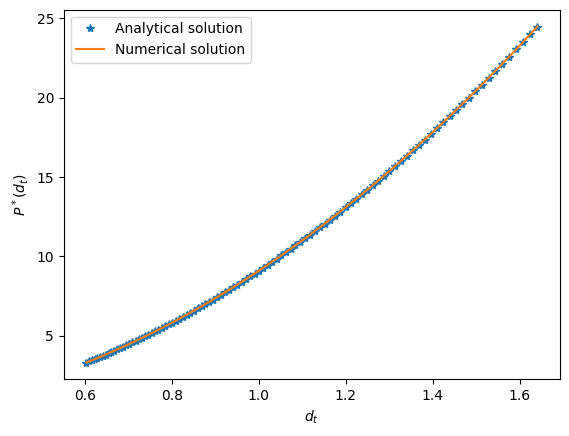

In [4]:
# Create an i.i.d. dividend process
σ = 0.1
iidDivs = DivProcess(α = 0.0, σ = σ)

# And an economy that embeds it
CRRA = 2
Disc = 0.9

iidEcon = LucasEconomy(CRRA=CRRA, DiscFac=Disc, DivProcess=iidDivs)
iidEcon.solve()

# Generate a function with our analytical solution
dTil = np.exp((σ**2) / 2 * CRRA * (CRRA - 1))

def aSolIID(d):
    return d**CRRA * dTil * Disc / (1 - Disc)


# Get a grid for d over which to compare them
dGrid = np.exp(iidDivs.getLogdGrid())

# Plot both
plt.figure()
plt.plot(dGrid, aSolIID(dGrid), "*", label="Analytical solution")
plt.plot(dGrid, iidEcon.EqPfun(dGrid), label="Numerical solution")
plt.legend()
plt.xlabel("$d_t$")
plt.ylabel("$P^*(d_t)$")
plt.show()

# Dividends that are a geometric random walk with drift

The notes also show that if the dividend process is
\begin{equation*}
\ln d_{t+1} = \gamma + \ln d_t + \varepsilon_{t+1}, \qquad \varepsilon \sim \mathcal{N}(-\frac{\sigma^2}{2}, \sigma).
\end{equation*}
so that $E_t[d_{t+1}/d_t] = e^\gamma$, then we have
\begin{equation*}
 P^*(d_t) = d_t^\rho\times e^{(\rho-1)\left(\rho\sigma^2/2 - \gamma\right)}\frac{\beta}{1-\beta}.
\end{equation*}

Text(0, 0.5, '$P^*(d_t)$')

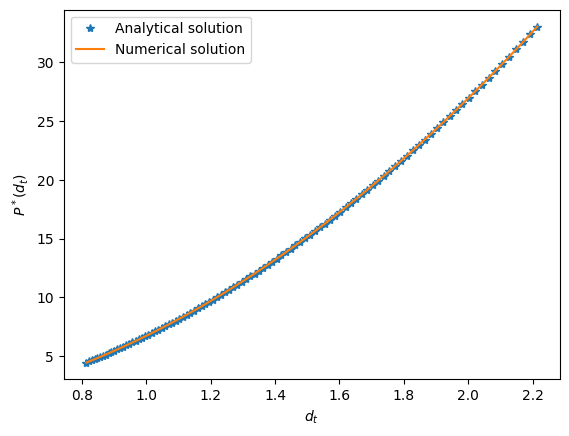

In [8]:
CRRA = 2
Disc = 0.9
σ = 0.1
γ = 0.3

# Create a random walk dividend process
# (it turns out that the whole model can be normalized by d_t, and
# in normalized, terms the dividend proces becomes iid again)
rw_divs = DivProcess(γ=γ, α = 0, σ = σ)

# And an economy that embeds it
rw_econ = LucasEconomy(CRRA = CRRA, DiscFac = Disc, DivProcess = rw_divs)
rw_econ.solve()

# Generate a function with our analytical solution
a_sol_factor = np.exp((CRRA-1)*(CRRA*σ**2/2 - γ))
a_sol_rw = lambda d: d**(CRRA) * a_sol_factor * Disc/(1 - Disc)

# Get a grid for d over which to compare them
dGrid = np.exp(rw_divs.getLogdGrid())

# Plot both
plt.figure()
plt.plot(dGrid, a_sol_rw(dGrid), '*',label = 'Analytical solution')
plt.plot(dGrid, rw_econ.EqPfun(dGrid), label = 'Numerical solution')
plt.legend()
plt.xlabel('$d_t$')
plt.ylabel('$P^*(d_t)$')

# Testing our approximation of the dividend process

Hidden in the solution method implemented above is the fact that, in order to make expectations easy to compute, we discretize the random shock $\varepsilon_t$, which is to say, we create a discrete variable $\tilde{\varepsilon}$ that approximates the behavior of $\varepsilon_t$. This is done using a [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature).

A parameter for the numerical solution is the number of different values that we allow our discrete approximation $\tilde{\varepsilon}$ to take, $n^{\#}$. We would expect a higher $n^#$ to improve our solution, as the discrete approximation of $\varepsilon_t$ improves. We test this below.

In [6]:
# Increase CRRA to make the effect of uncertainty more evident.
CRRA = 10
Disc = 0.9
σ = 0.1
ns = [1, 2, 10]

dTil = np.exp((σ**2) / 2 * CRRA * (CRRA - 1.0))

def aSolIID(d):
    return d**CRRA * dTil * Disc / (1 - Disc)

dGrid = np.exp(iidDivs.getLogdGrid())

plt.figure()
for n in ns:
    iidDivs = DivProcess(α=0.0, σ=σ, nApprox=n)
    iidEcon = LucasEconomy(CRRA=CRRA, DiscFac=Disc, DivProcess=iidDivs)
    iidEcon.solve()
    plt.plot(dGrid, iidEcon.EqPfun(dGrid), label="Num.Sol. $n^\#$ = {}".format(n))

# Plot both
plt.plot(dGrid, aSolIID(dGrid), "*", label="Analytical solution")
plt.legend()
plt.xlabel("$d_t$")
plt.ylabel("$P^*(d_t)$")
plt.show()